<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/Hierarchical_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You might need the data from here: http://www.stat.columbia.edu/~gelman/arm/examples/election88/

In [1]:
!pip install pyreadstat pyro-ppl

     |████████████████████████████████| 2.4 MB 9.2 MB/s 
     |████████████████████████████████| 718 kB 21.7 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [4]:
import pyreadstat

import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

from torch import nn
from pyro.nn import PyroModule
from pyro.infer import MCMC, NUTS, Predictive

import sklearn.model_selection

polls_df, meta = pyreadstat.read_dta('polls.dta')
polls_df = polls_df.dropna()
presvote_df, _ = pyreadstat.read_dta('presvote.dta')

In [5]:
# Apologies, for this, this is how they do it in the R code as well. 
# The list has length 51 since they add D.C as its own state.
state_to_region_mapping = torch.tensor([3,4,4,3,4,4,1,1,5,3,3,4,4,2,2,2,2,3,3,1,1,1,2,2,3,2,4,2,4,1,1,4,1,3,2,2,3,4,1,1,3,2,3,3,4,1,3,4,1,2,4])
state_to_region_mapping = state_to_region_mapping.repeat(len(polls_df), 1)
indices = torch.tensor(polls_df['state'].values, dtype=torch.int64) - 1
polls_df['region'] = state_to_region_mapping.gather(1, indices.view(-1, 1))

In [6]:
polls_df['black_female'] = polls_df['black']*polls_df['female']
polls_df['age_edu'] = polls_df['age']*polls_df['edu']

In [7]:
presvote_df = presvote_df.rename(columns={'stnum2': 'state', 'g76_84pr':'previous_vote'})

In [8]:
polls_df = polls_df.join(other=presvote_df.set_index('state'), on='state')

In [9]:
polls_df['age'] = polls_df['age'] - 1
polls_df['edu'] = polls_df['edu'] - 1
polls_df['region_full'] = polls_df['region'] - 1
polls_df['state'] = polls_df['state'] - 1


@All: Need to check that the preprocessing is correct; In my opinion the model assumes / requires that all variables are transformed such that they lie in {0, 1, ..., n_distinct_elemts}

In [10]:
age = torch.tensor(polls_df[["age"]].values, dtype=torch.int64)
edu = torch.tensor(polls_df[["edu"]].values, dtype=torch.int64)
age_edu = torch.tensor(polls_df[["age_edu"]].values, dtype=torch.int64)
state = torch.tensor(polls_df[["state"]].values, dtype=torch.int64)
region_full = torch.tensor(polls_df[["region"]].values, dtype=torch.int64)
female = torch.tensor(polls_df[["black"]].values, dtype=torch.int64)
black = torch.tensor(polls_df[["female"]].values, dtype=torch.int64)
v_prev_full = torch.tensor(polls_df[['previous_vote']].values, dtype = torch.float64)
y = torch.tensor(polls_df[["bush"]].values,  dtype=torch.float64)

n_age_categories = max(age) + 1
n_edu_categories = max(edu) + 1
n_age_edu_categories = max(age_edu) + 1
n_state_categories = max(state) + 1
n_region_full_categories = max(region_full) + 1

In [11]:
def get_features_and_targets(dataframe):
  feature_names = ["female", "black", "previous_vote", "age", "edu", "age_edu", "region", "state"]
  features = []
  for feature in feature_names:
    if feature == "previous_vote":
      dtype = torch.float64
    else:
      dtype = torch.int64
    
    features.append(torch.tensor(dataframe[[feature]].values, dtype=dtype))
  targets = torch.tensor(dataframe[["bush"]].values,  dtype=torch.float64)
  return features, targets

In [12]:
train_df, test_df = sklearn.model_selection.train_test_split(polls_df, train_size=10000)

In [13]:
train_features, train_targets = get_features_and_targets(train_df)
test_features, test_targets = get_features_and_targets(test_df)


In [14]:
def model(female, black, v_prev_full, age, edu, age_edu, region_full, state, y):
      #Unifrom hyper-priors constraint between 0 and 100 for variances
      sigma_a = pyro.sample('sigma_a', dist.Uniform(0., 100.))
      sigma_b = pyro.sample('sigma_b', dist.Uniform(0., 100.))
      sigma_c = pyro.sample('sigma_c', dist.Uniform(0., 100.))
      sigma_d = pyro.sample('sigma_d', dist.Uniform(0., 100.))
      sigma_e = pyro.sample('sigma_e', dist.Uniform(0., 100.))
      
      #priors for hierarchical log reg
      beta = pyro.sample('beta', dist.Normal(0., 100.).expand([5]).to_event(1))
      a = pyro.sample("a", dist.Normal(0., sigma_a).expand(n_age_categories).to_event(1))
      b = pyro.sample("b", dist.Normal(0., sigma_b).expand(n_edu_categories).to_event(1))
      c = pyro.sample("c", dist.Normal(0., sigma_c).expand(n_age_edu_categories).to_event(1))
      d = pyro.sample("d", dist.Normal(0., sigma_d).expand(n_state_categories).to_event(1))
      e = pyro.sample("e", dist.Normal(0., sigma_e).expand(n_region_full_categories).to_event(1))

      #logits
      logits = beta[0] \
            +beta[1]*black \
            +beta[2]*female \
            +beta[4]*female*black \
            +beta[3]+v_prev_full \
            +a[age] \
            +b[edu] \
            +c[age_edu] \
            +d[state] \
            +e[region_full]

      with pyro.plate("data", len(logits)):
        obs = pyro.sample("obs", dist.Bernoulli(logits = logits).to_event(1), obs=y)

In [15]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal

guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [16]:
pyro.clear_param_store()

step_ids = []
average_log_predictives = []
for j in range(2000):
    # calculate the loss and take a gradient step
    loss = svi.step(*train_features, train_targets)
    print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(train_targets)))

    if j % 10 == 0:
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)
      train_predictions = predictive_svi(*train_features, None)
      test_predictions = predictive_svi(*test_features, None)
      train_obs = train_predictions['obs'].numpy()
      test_obs = test_predictions['obs'].numpy()
      average_train_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(train_obs) ==  torch.tile(train_targets, (num_samples, 1, 1)), axis=1)/len(train_targets)))
      average_test_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(test_obs) ==  torch.tile(test_targets, (num_samples, 1, 1)), axis=1)/len(test_targets)))
      print(average_train_log_accuracy)
      print(average_test_log_accuracy)

      step_ids.append(j)
      average_log_predictives.append(average_test_log_accuracy)
    

[iteration 0001] loss: 61.4473
tensor(-0.5752)
tensor(-0.5912)
[iteration 0002] loss: 61.1978
[iteration 0003] loss: 60.9623
[iteration 0004] loss: 60.4375
[iteration 0005] loss: 60.0672
[iteration 0006] loss: 59.7292
[iteration 0007] loss: 59.4279
[iteration 0008] loss: 58.9535
[iteration 0009] loss: 58.8091
[iteration 0010] loss: 58.2541
[iteration 0011] loss: 58.0769
tensor(-0.5743)
tensor(-0.5913)
[iteration 0012] loss: 57.6859
[iteration 0013] loss: 57.4149
[iteration 0014] loss: 57.0843
[iteration 0015] loss: 56.7309
[iteration 0016] loss: 56.3207
[iteration 0017] loss: 55.9382
[iteration 0018] loss: 55.5876
[iteration 0019] loss: 55.3621
[iteration 0020] loss: 54.8092
[iteration 0021] loss: 54.5340
tensor(-0.5750)
tensor(-0.5923)
[iteration 0022] loss: 54.2400
[iteration 0023] loss: 53.8365
[iteration 0024] loss: 53.4861
[iteration 0025] loss: 53.2594
[iteration 0026] loss: 52.9547
[iteration 0027] loss: 52.5623
[iteration 0028] loss: 52.2139
[iteration 0029] loss: 51.8596
[iter

Text(0, 0.5, 'Average log predictive')

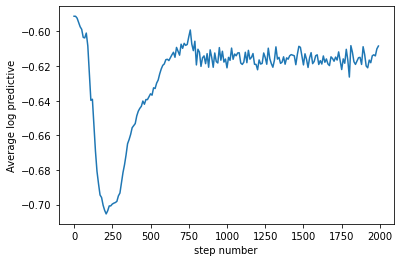

In [17]:
plt.plot(step_ids, average_log_predictives)
plt.xlabel("step number")
plt.ylabel("Average log predictive")

In [18]:
guide.requires_grad_(False)
guide.quantiles([0.5])

{'a': tensor([[-13.4808, -11.9820, -12.3895, -10.5449]]),
 'b': tensor([[-32.0755, -30.1352, -30.3376, -28.7695]]),
 'beta': tensor([[27.8124, -2.2058, -0.1499, 47.9511,  0.3970]]),
 'c': tensor([[  0.0724,  -5.1408,  -6.7108,  -6.6197,  -8.6027,   0.9903,  -8.2248,
           -1.6325,  -9.9438,  -7.8078,   0.2100,  -0.0364,  -9.6195,   0.1262,
           -0.8612,   0.0643, -11.0049]]),
 'd': tensor([[-10.1257,  -0.8830, -17.4378, -10.9774, -17.4133, -17.3247, -20.2849,
          -20.5499, -26.2862, -10.7359, -10.6115,  -0.5222, -17.8004, -10.4042,
           -9.9053, -11.2777,  -9.6726, -10.8325, -10.1182, -20.0605, -19.8752,
          -20.3431, -10.3475, -10.5830,  -9.8244, -10.6808, -17.9674, -10.4493,
          -17.1376, -19.4681, -19.9855, -17.4763, -20.3228, -10.7771, -10.4824,
          -10.1609, -11.1858, -17.5151, -20.1460, -21.1185, -10.0607, -10.5858,
          -10.2932, -10.9669, -16.4136, -20.0648, -10.4823, -17.8811, -20.0321,
          -10.6661, -17.2438]]),
 'e': tensor

In [ ]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model, jit_compile=False, step_size=.5)
num_samples = 100
mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=30,
    num_chains=1,
)

mcmc_step_ids = []
mcmc_average_test_log_accuracy = []


#samples = mcmc.get_samples()
#mcmc_predictive = Predictive(model, samples)(*test_features, None)
#test_obs = mcmc_predictive['obs'].numpy()
#average_test_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(test_obs) ==  torch.tile(test_targets, (num_samples, 1, 1)), axis=1)/len(test_targets)))
#mcmc_average_test_log_accuracy.append(average_test_log_accuracy)

for i in range(10):
  mcmc.run(*train_features, train_targets)
  #mcmc.summary(prob=0.5)
  samples = mcmc.get_samples()
  mcmc_predictive = Predictive(model, samples)(*test_features, None)
  test_obs = mcmc_predictive['obs'].numpy()
  average_test_log_accuracy = torch.mean(torch.log(torch.sum(torch.tensor(test_obs) ==  torch.tile(test_targets, (num_samples, 1, 1)), axis=1)/len(test_targets)))
  mcmc_step_ids.append(i)
  mcmc_average_test_log_accuracy.append(average_test_log_accuracy)

Sample:  91%|█████████ | 118/130 [02:48,  3.38s/it, step size=2.63e-02, acc. prob=0.822]

In [29]:
mcmc.diagnostics()

{'a': OrderedDict([('n_eff',
               tensor([16.3923, 16.3923, 16.3923, 16.3923], dtype=torch.float64)),
              ('r_hat',
               tensor([1.0553, 1.0553, 1.0553, 1.0553], dtype=torch.float64))]),
 'acceptance rate': {'chain 0': 0.02},
 'b': OrderedDict([('n_eff',
               tensor([16.3923, 16.3923, 16.3923, 16.3923], dtype=torch.float64)),
              ('r_hat',
               tensor([1.0553, 1.0553, 1.0553, 1.0553], dtype=torch.float64))]),
 'beta': OrderedDict([('n_eff',
               tensor([16.3923, 16.3923, 16.3923, 16.3923, 16.3923], dtype=torch.float64)),
              ('r_hat',
               tensor([1.0553, 1.0553, 1.0553, 1.0553, 1.0553], dtype=torch.float64))]),
 'c': OrderedDict([('n_eff',
               tensor([16.3923, 16.3923, 16.3923, 16.3923, 16.3923, 16.3923, 16.3923, 16.3923,
                       16.3923, 16.3923, 16.3923, 16.3923, 16.3923, 16.3923, 16.3923, 16.3923,
                       16.3923], dtype=torch.float64)),
              (

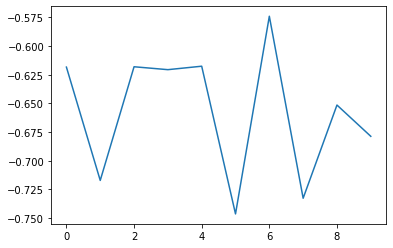

In [28]:
plt.plot(mcmc_step_ids, mcmc_average_test_log_accuracy)